In [463]:
import multiprocessing as mp

import string
import pickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

In [464]:
language = 'es'
assert(language in ['en', 'fr', 'es'])

In [465]:
numberbatch = pickle.load(open(f"/data/zeste_cache/numberbatch-{language}-19.08.pickle", 'rb'))

In [466]:
len(numberbatch.vocab)

651859

In [467]:
! ls datasets/silknow

en_material_post2.csv	  zeste_material_en_post.csv
en_technique_post2.csv	  zeste_material_es_post.csv
es_material_post2.csv	  zeste_technique_en_post.csv
es_technique_post2.csv	  zeste_technique_es_post.csv
es_visual_item_post2.csv  zeste_visual_item_es_post.csv


In [468]:
ds_techniques = pd.read_csv('datasets/silknow/zeste_material_es_post.csv').rename(columns={'material':'label'})
ds_techniques.label = ds_techniques.label.str.lower()
ds_techniques.head()

,text,label
0,Los travesaños repuestos en el asiento y respa...,http://data.silknow.org/vocabulary/214
1,Edad Moderna,http://data.silknow.org/vocabulary/214
2,Silla de brazos de madera de nogal sobre zapat...,http://data.silknow.org/vocabulary/214
3,La voluta tallada en las caras exteriores de l...,http://data.silknow.org/vocabulary/214
4,Estructura (elemento mobiliario): Edad Contemp...,http://data.silknow.org/vocabulary/214


In [469]:
ds_techniques.label.value_counts()

http://data.silknow.org/vocabulary/214    249
http://data.silknow.org/vocabulary/627     61
http://data.silknow.org/vocabulary/628     22
Name: label, dtype: int64

In [470]:
len(ds_techniques)

332

In [471]:
def get_word_neighborhood(word, depth=2, allowed_rels='all', keep='top20000', language=language):
    neighborhood = pickle.load(open('/data/zeste_cache/neighborhoods_'+language+'/'+word+'.pickle', 'rb'))
    neighborhood_words = list(neighborhood.keys())
    
    if allowed_rels != 'all':
        for n in neighborhood_words:
            if all(rel not in neighborhood[n]['rels'] for rel in allowed_rels):
                del neighborhood[n]
                continue

    to_visit_next = list(neighborhood.keys())
    
    while depth > 1:
        additions = []
        while len(to_visit_next) > 0:
            w = to_visit_next.pop()
            nn = get_word_neighborhood(w, depth=1, allowed_rels=allowed_rels)
            for ww in nn:
                if ww in neighborhood:
                    neighborhood[ww]['from'].append(w)
                    neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                else:
                    neighborhood[ww] = {}
                    neighborhood[ww]['from'] = [w]
                    neighborhood[ww]['rels'] = nn[ww]['rels']
                    if '/c/'+language+'/'+word in numberbatch and '/c/'+language+'/'+ww in numberbatch:
                        neighborhood[ww]['sim'] = numberbatch.similarity('/c/'+language+'/'+word, '/c/'+language+'/'+ww)
                    else:
                        neighborhood[ww]['sim'] = 0.0
                    additions.append(ww)
        to_visit_next = additions
        depth -= 1
    
    if keep.startswith('top'):
        k = int(keep.split('top')[1])
        all_scores = [neighborhood[kw]['sim'] for kw in neighborhood]
        all_words = list(neighborhood.keys())
        if k < len(all_scores):
            lowest_top = sorted(all_scores, reverse=True)[k]
            for kw in all_words:
                if neighborhood[kw]['sim'] <= lowest_top:
                    del neighborhood[kw]
    
    return neighborhood

In [472]:
def preprocess(doc):
    doc = ''.join(c for c in doc if c not in string.punctuation or c == ' ').lower()
    doc_tokens = doc.split(' ')
    doc_tokens = [w.lower() for w in doc_tokens]
    doc_tokens = [w for w in doc_tokens if w not in stopwords.words('english')]
    doc_tokens = [w.replace('"', '').replace('?', '') for w in doc_tokens]
    doc_tokens = [w.replace('-', '_') for w in doc_tokens if w != '']

    return doc_tokens

In [473]:
def get_words_neighborhood(words, depth=2, allowed_rels='all', keep='top20000', language=language):
    words = words.split(';')
    ns = []
    
    for word in words:
        ns.append(get_word_neighborhood(word, depth=depth, allowed_rels=allowed_rels, keep=keep, language=language))
    neighborhood = ns[0].copy()
    
    for w, nn in zip(words[1:], ns[1:]):
        for ww in nn:
            if ww in neighborhood:
                neighborhood[ww]['from'].append(w)
                neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                neighborhood[ww]['sim'] = max(neighborhood[ww]['sim'], nn[ww]['sim'])
            else:
                neighborhood[ww] = {}
                neighborhood[ww]['from'] = [w]
                neighborhood[ww]['rels'] = nn[ww]['rels']
                neighborhood[ww]['sim']  = nn[ww]['sim']

    return neighborhood

In [474]:
sorted(ds_techniques.label.unique())

['http://data.silknow.org/vocabulary/214',
 'http://data.silknow.org/vocabulary/627',
 'http://data.silknow.org/vocabulary/628']

In [475]:
get_word_neighborhood('rose', 1, 'all').keys()

dict_keys(['rose', 'rosal', 'rosáceo', 'rosa', 'rosado', 'rosaleda', 'rosalista', 'pimpollo'])

In [476]:
"""mapping = {  'brocade': 'brocade',
             'brocatelle': 'brocatelle',
             'chiné': 'chiné',
             'damask': 'damask',
             'embroidery': "embroidery",
             'florentine': "florentine",
             'gros': "gros",
             'jacquard weave': "jacquard_loom",
             'lampas': "lampas",
             'moiré' : 'moiré',
             'pattern weft': "weft",
             'plain': "plain",
             'velvet': "velvet"}"""

mapping = { 'http://data.silknow.org/vocabulary/214':'vegetal',
            'http://data.silknow.org/vocabulary/627':'oro',     
            'http://data.silknow.org/vocabulary/628':'plata' }

labels = sorted(set(mapping.values()))
print(len(labels))
print(labels)

3
['oro', 'plata', 'vegetal']


In [477]:
%%time
pbar = tqdm(labels)

labels_cgr = {}
for label in pbar:
    pbar.set_description(label)
    labels_cgr[label] = get_words_neighborhood(label, 2, 'all', keep='top20000')


CPU times: user 74.6 ms, sys: 1.16 ms, total: 75.7 ms
Wall time: 71.4 ms


In [478]:
{l:len(labels_cgr[l]) for l in labels_cgr}

{'oro': 510, 'plata': 405, 'vegetal': 140}

In [479]:
labels_cgr.keys()

dict_keys(['oro', 'plata', 'vegetal'])

In [480]:
def get_document_score(doc, label_neighborhood):
    # tokens = preprocess(doc)
    if type(doc) == str:
        doc = doc.split(' ')
    tokens = doc
    related_words = []
    score = 0
    for token in tokens: 
        if token in label_neighborhood:
            similarity = label_neighborhood[token]['sim']
            if similarity > 0:
                related_words.append((token, label_neighborhood[token]['rels'][0], similarity))
                score += similarity
        
    return score# , sorted(related_words, key=lambda t: -t[-1])

In [481]:
ds_techniques.text[0]

'Los travesaños repuestos en el asiento y respaldo indican que se trata de una pieza, que haya sido retapizada con tejidos antiguos. Las alteraciones en la pieza y el cepillado de la superficie indican que en el momento del retapizado ya debió de tener cierta antigüedad su estructura. El perfil de la chambrana frontal remite a otros ejemplares o en madera vista tallada, o bien a la silla de brazos chapeada con marfil y maderas exóticas, conservada en el Instituto de Valencia de Don Juan con Nº inv. I 4926, fechable en la primera mitad del siglo XVII [ver El mundo que vivió Cervantes (Cat. Exp.), 2005, Centro Cultural de la Villa, Madrid, 11.10.2005-08.01.2006, , Madrid, Sociedad Estatal de Conmemoraciones Culturales: 453; nº cat. 259, ficha de Casto Castellanos Ruiz, con inversión de la foto con la ficha siguiente].'

In [482]:
data_silknow = ds_techniques.text.tolist()

In [483]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  32


In [484]:
%%time
with mp.Pool(mp.cpu_count()) as pool:
    data_preprocessed = pool.map(preprocess, ds_techniques.text)

CPU times: user 0 ns, sys: 1.55 s, total: 1.55 s
Wall time: 1.58 s


In [485]:
def scoring_silknow(doc, labels_ns=labels_cgr):
    return np.argmax([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])

In [486]:
def generate_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow, corpus_preprocessed)
    return predictions

In [487]:
%%time
predictions = generate_predictions(data_preprocessed, labels_cgr)

CPU times: user 0 ns, sys: 1.41 s, total: 1.41 s
Wall time: 1.36 s


In [488]:


predictions[:10]

[1, 0, 1, 1, 0, 1, 1, 1, 0, 1]

In [489]:

prediction_labels = [labels[p] for p in predictions]

In [490]:
set(prediction_labels)

{'oro', 'plata', 'vegetal'}

In [491]:
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]

# Materials

In [492]:
print(classification_report(prediction_labels, true_labels, digits=3))
m = np.asarray(prediction_labels)
ds_techniques["predictions"] = m 
ds_techniques.to_csv('materials-es-predictions.csv')

              precision    recall  f1-score   support

         oro      0.639     0.149     0.242       261
       plata      0.545     0.211     0.304        57
     vegetal      0.044     0.786     0.084        14

    accuracy                          0.187       332
   macro avg      0.410     0.382     0.210       332
weighted avg      0.598     0.187     0.246       332



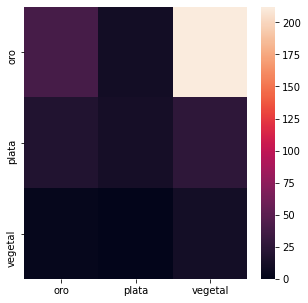

In [493]:
cm = confusion_matrix(prediction_labels, true_labels)
cm_df = pd.DataFrame(cm, columns=labels, index=labels)
plt.figure(figsize = (5,5))
sns.heatmap(cm_df)

# "Top-k" evaluation

In [494]:
k = 2
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions

In [495]:
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

         oro      0.689     0.857     0.764        49
       plata      0.818     0.439     0.571        41
     vegetal      0.896     0.921     0.908       242

    accuracy                          0.852       332
   macro avg      0.801     0.739     0.748       332
weighted avg      0.855     0.852     0.845       332



In [496]:
k = 3
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

         oro      1.000     1.000     1.000        61
       plata      1.000     1.000     1.000        22
     vegetal      1.000     1.000     1.000       249

    accuracy                          1.000       332
   macro avg      1.000     1.000     1.000       332
weighted avg      1.000     1.000     1.000       332

